In [1]:
import pandas as pd
import numpy as np
import logging
import gc
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

import sys
sys.path.append("../")

import src.features.outlier_correction as oc
from src.models import record_model
from src.features import build_features

# Set up data dir
data_dir = "data/processed/"

# Define arguments to be passed to model
epochs=50
batch_size=64
num_outputs=1
num_features=100
hidden_layers=2
n_sd = 4

Using TensorFlow backend.


In [6]:
train_feats = pd.read_csv("../data/processed/train_features.csv")
train_target = pd.read_csv("../data/processed/train_target.csv")

train_feats.set_index('card_id', inplace=True)
train_target.set_index('card_id', inplace=True)

outliers = oc.flag_normal_outliers(train_target, n_sd)

if outliers.values.any():
    outliers = outliers.values.reshape(-1)
    train_feats = train_feats[~outliers]
    train_target = train_target[~outliers]

del outliers
gc.collect()

feat_types = ["SUM", "MIN", "MAX", "STD", "COUNT"]
use_feats = [c for c in train_feats.columns if any([f in c for f in feat_types])]

X_train = train_feats[use_feats].values
y_train = train_target.values.reshape(-1)

num_inputs = X_train.shape[1]

In [7]:
use_feats

['SUM(transactions.city_id)',
 'SUM(transactions.authorized_flag)',
 'SUM(transactions.installments)',
 'SUM(transactions.month_lag)',
 'SUM(transactions.purchase_amount)',
 'STD(transactions.city_id)',
 'STD(transactions.authorized_flag)',
 'STD(transactions.installments)',
 'STD(transactions.month_lag)',
 'STD(transactions.purchase_amount)',
 'MAX(transactions.city_id)',
 'MAX(transactions.installments)',
 'MAX(transactions.month_lag)',
 'MAX(transactions.purchase_amount)',
 'MIN(transactions.city_id)',
 'MIN(transactions.authorized_flag)',
 'MIN(transactions.installments)',
 'MIN(transactions.month_lag)',
 'MIN(transactions.purchase_amount)',
 'COUNT(transactions)']

In [8]:
# Define the model
model = Sequential()
model.add(Dense(batch_size, input_dim=num_inputs, kernel_initializer='normal', activation='relu'))
model.add(Dense(batch_size, kernel_initializer='normal', activation='relu'))
model.add(Dense(num_outputs, kernel_initializer='normal'))
# Compile model
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy', 'mae'])

Instructions for updating:
Colocations handled automatically by placer.


2019-04-11 08:20:37,859 - tensorflow - WARNING - From /Users/kennedymurphy/elo/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
# fit
history = model.fit(X_train, y_train, validation_split=0.33, verbose=0, epochs=epochs, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.


2019-04-11 08:20:38,975 - tensorflow - WARNING - From /Users/kennedymurphy/elo/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


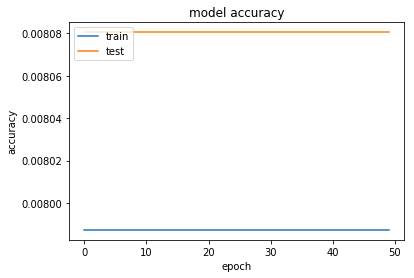

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

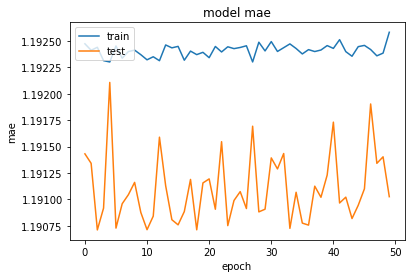

In [11]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

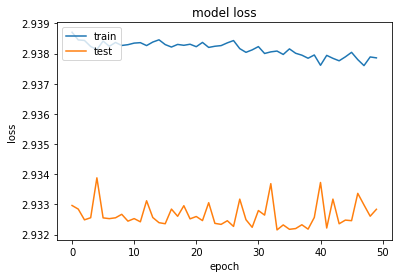

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()